In [1]:
# Database
import sqlite3

# Machine learning
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split

# NLP
import spacy

# Plots
import matplotlib.pyplot as plt

# Own fns
import preprocessing
import model_utils as model_utils


# 0. Fetch data from db

In [2]:
database_file_name = "db_analytic_multi-class.sqlite"

con = sqlite3.connect(f"../../db/{database_file_name}")

cur = con.cursor()

In [3]:
sql_file_name = "select_all_text_multi-class.sql"

# TODO: Use sqlutils.get_sql_statement()
with open(f"../../db/sql/{sql_file_name}") as sql_file:
    sql = sql_file.read()
    sql_file.close()

cur.execute(sql)

'''
Response format: list[(text, categories)]
'''
response = cur.fetchall()

In [4]:
# TODO: Vérifier l'equilibrage des classes
data_dict = {}
'''
Format: {[list[categories]]: list[page_text_content]}
'''

for page in response:
    text = page[0]
    raw_categories: str = page[1]

    if raw_categories is None:
        continue

    categories = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

    for elt in raw_categories.split(","):
        categories[int(elt)] = 1

    categories = str(categories)[1:-1].replace(" ","")

    if categories not in list(data_dict.keys()):
        data_dict[categories] = [text]
    else :
        data_dict[categories].append(text)

print(len(data_dict[list(data_dict.keys())[0]]))

125


# 1. Cleaning

In [5]:
cleaned_data_dict = {}
nlp = spacy.load("fr_core_news_lg")

for category in list(data_dict.keys()):
    cleaned_data_dict[category] = []

for category in list(data_dict.keys()):
    for text_content in data_dict[category]:
        cleaned_text = preprocessing.full_cleaning(text_content, nlp)

        cleaned_data_dict[category].append(cleaned_text)

print(cleaned_data_dict)

{'0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0': ['entretenir exterieur travail exterieur ryobi debroussailleus an debroussailleus ryobi electriqu wv ideal travail finition petit herbe haut retrouver outil coupe coupe net precise tete semi automatique double fil cm avancer automatique fil simple ryobi pression sol lame taillis dent cm double affutage dent reversibl ref eco part recyclage combine an combine taille haie perche electriqu ryobi rp appareil filaire usage perche branche tailler haie hauteur demontabl facile ranger perche puissant moteur ideal petit elagage pack an incliner precision confort longueur maximal cm tube extension fibr verre cm leger maniable harnais bretell pack tondeus up ergonomique niveau huile visible controle facile rapide ref kit comprendre tondeus cm batterie ov sah eco part recyclage chargeur standard jusqua autonomie charg batteri tonte reguliere tondeus cm fil batterie up allier puissance autonomie faciliter utilisation liberte mouvement emet aucun emission polluant

# 2. Create a vocabulary

In [6]:
# String containing all the words
all_text = ""

for category in list(cleaned_data_dict.keys()):
    temp_text = " ".join(cleaned_data_dict[category])
    print(temp_text)

    if category == list(cleaned_data_dict.keys())[0]:
        all_text += temp_text
    else:
        all_text += " " + temp_text

vocabulary = np.unique(all_text.split(" "))
print(list(vocabulary))
print(len(list(vocabulary)))

entretenir exterieur travail exterieur ryobi debroussailleus an debroussailleus ryobi electriqu wv ideal travail finition petit herbe haut retrouver outil coupe coupe net precise tete semi automatique double fil cm avancer automatique fil simple ryobi pression sol lame taillis dent cm double affutage dent reversibl ref eco part recyclage combine an combine taille haie perche electriqu ryobi rp appareil filaire usage perche branche tailler haie hauteur demontabl facile ranger perche puissant moteur ideal petit elagage pack an incliner precision confort longueur maximal cm tube extension fibr verre cm leger maniable harnais bretell pack tondeus up ergonomique niveau huile visible controle facile rapide ref kit comprendre tondeus cm batterie ov sah eco part recyclage chargeur standard jusqua autonomie charg batteri tonte reguliere tondeus cm fil batterie up allier puissance autonomie faciliter utilisation liberte mouvement emet aucun emission polluant utilisation ref eco part recyclage ry

In [7]:
# Save the vocabulary
vocabulary_file_name = "vocab_multi-class.txt"

with open(f"./{vocabulary_file_name}", "w") as vocabulary_file:
    for token in list(vocabulary):
        if token == list(vocabulary)[-1]:
            vocabulary_file.write(token)
        else:
            vocabulary_file.write(token+"|")
    
    vocabulary_file.close()

# 3. Feature extraction (BOW)

In [8]:
X = []
y = []

for category in list(cleaned_data_dict.keys()):
    for text in cleaned_data_dict[category]:
        X.append(preprocessing.get_bags_of_words_vector(text, vocabulary))
        y.append(category.split(","))

print(len(X))
print(len(y))

1203
1203


# 4. Model

In [9]:
class PageClassifierMultiLabel(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, 128),
            nn.ReLU(),
            nn.Linear(128, output_features),
            nn.Sigmoid(),  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# 5. Training

In [10]:
def accuracy_fn(y_true, y_pred):
    new_y_pred = []
    threshold = 0.5
    
    for elt in y_pred:
        new_elt = []
        for subelt in elt:
            if subelt >= threshold:
                new_elt.append(1)
            else:
                new_elt.append(0)
        new_y_pred.append(new_elt)

    new_y_pred = torch.tensor(new_y_pred).type(torch.float32)

    correct = 0
    for i in range(len(new_y_pred)):
        if list(new_y_pred[i]) == list(y_true[i]):
            correct +=1
    acc = (correct / len(y_pred)) * 100  # nd de prediction correcte / total des prediction
    return acc

In [11]:
# TODO: Put in utils file
def display_training_metrics(
    epochs: int,
    loss_history: list[float],
    test_loss_history: list[float],
    acc_history: list[float],
    test_acc_history: list[float],
):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Training loss")
    plt.plot(range(epochs), test_loss_history, label="Testing loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), acc_history, label="Training acc")
    plt.plot(range(epochs), test_acc_history, label="Testing acc")
    plt.legend()
    plt.title("Accuracy")

    plt.show()

In [18]:
def training_loop(PageClassifier, X, y):
    loss_history, acc_history, val_loss_history, val_acc_history = [], [], [], []

    # Init model
    torch.manual_seed(42)
    
    model = PageClassifier(input_features=len(X[0]), output_features=16)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Prepare data
    X = torch.tensor(X).type(torch.float32)

    y_copy = y
    y = []
    for elt in y_copy:
        # print("elt", elt)
        new_elt = []
        for subelt in elt:
            # print("subelt", subelt)
            new_elt.append(int(subelt))
        y.append(new_elt)

    y = torch.tensor(y).type(torch.float32)


    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Training loop
    torch.manual_seed(42)
    epochs = 100

    for epoch in range(epochs):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        y_pred_probs = torch.sigmoid(y_logits)

        # 2. Metrics
        loss = loss_fn(y_pred_probs, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred_probs)

        # 2.1 Save metrics
        loss_history.append(loss.cpu().detach().numpy())
        acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Validation
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_val_logits = model(X_val)
            y_val_pred_probs = torch.sigmoid(y_val_logits)


            # 2. Metrics
            val_loss = loss_fn(y_val_pred_probs, y_val)
            val_acc = accuracy_fn(y_true=y_val, y_pred=y_val_pred_probs)

            # 2.1 Save metrics
            val_loss_history.append(val_loss.cpu().detach().numpy())
            val_acc_history.append(val_acc)

        # Print out what's happening
        # if epoch % 25 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {val_loss:.5f}, Test Acc: {val_acc:.2f}%"
        )
    display_training_metrics(
        epochs, loss_history, val_loss_history, acc_history, val_acc_history
    )
    return model

Epoch: 0 | Loss: 0.68836, Acc: 0.00% | Test Loss: 0.42885, Test Acc: 23.65%
Epoch: 1 | Loss: 0.41718, Acc: 25.88% | Test Loss: 0.26245, Test Acc: 19.09%
Epoch: 2 | Loss: 0.25733, Acc: 22.66% | Test Loss: 0.19205, Test Acc: 26.56%
Epoch: 3 | Loss: 0.17979, Acc: 26.92% | Test Loss: 0.15785, Test Acc: 38.17%
Epoch: 4 | Loss: 0.13808, Acc: 44.18% | Test Loss: 0.14078, Test Acc: 57.68%
Epoch: 5 | Loss: 0.11709, Acc: 61.23% | Test Loss: 0.12896, Test Acc: 63.49%
Epoch: 6 | Loss: 0.09855, Acc: 65.49% | Test Loss: 0.11503, Test Acc: 63.90%
Epoch: 7 | Loss: 0.07806, Acc: 68.71% | Test Loss: 0.09891, Test Acc: 66.80%
Epoch: 8 | Loss: 0.05918, Acc: 75.47% | Test Loss: 0.08472, Test Acc: 70.12%
Epoch: 9 | Loss: 0.04532, Acc: 83.16% | Test Loss: 0.07593, Test Acc: 75.10%
Epoch: 10 | Loss: 0.03667, Acc: 87.11% | Test Loss: 0.07198, Test Acc: 78.01%
Epoch: 11 | Loss: 0.03134, Acc: 88.88% | Test Loss: 0.07084, Test Acc: 78.84%
Epoch: 12 | Loss: 0.02749, Acc: 89.92% | Test Loss: 0.07000, Test Acc: 79.6

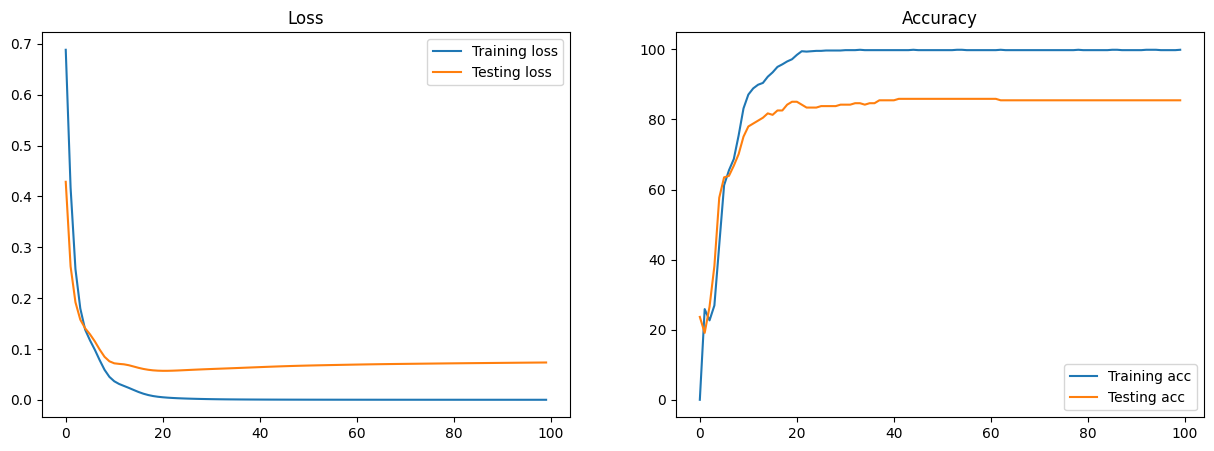

In [19]:
model = training_loop(model_utils.PageClassifier, X, y)

# 6. Save the model

In [15]:
torch.save(model.state_dict(), "./model_weight_multi-class.pth")

# 7. Prediction

In [16]:
# def predict(model, input: list[int], label_mapping: dict[str]):
#     model.eval()

#     with torch.inference_mode():
#         X = torch.tensor([input]).type(torch.float32)
#         y_logits = model(X)
#         y_softmax = torch.softmax(y_logits, dim=1)
#         y_pred = y_softmax.argmax(dim=1)
        
#         result = y_softmax.detach().numpy()
#         class_prediction = label_mapping[y_pred.detach().numpy()[0]]

#         print("result", result)
#         print("class_prediction =>", class_prediction)

In [18]:
# TODO: Use real test data
input = preprocessing.pipeline_from_raw_text_to_vectors(
    data_dict[1][-1], nlp, vocabulary
)
print(input)
model_utils.predict(model, input)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

1

TODO:
- Try auto-sklearn
- Try lazy predict
- Create model.py (with pytorch)